In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from src.dataset import get_dataloaders
from src.utils import evaluate, set_random_seed, plot_confusion_matrixb

import matplotlib.pyplot as plt
import os
import gdown


%matplotlib inline

set_random_seed()

test_transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor()]
)

test_dataset = datasets.ImageFolder(root="./data/test_set", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes

In [1]:
!python3 download_models.py

In [4]:
from src.models import load_vit_model

model_path = "./dino.pth"
model = load_vit_model("dinov2").to("cuda")

state_dict = torch.load(model_path)
# Remove _orig_mod. from all keys since we are using torch.compile(model) while training
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [5]:
r1, r5 = evaluate(model, test_loader, "cuda")
print(f"Top-1: {r1:.2f}%, Top-5: {r5:.2f}")

Top-1: 80.37%, Top-5: 94.43


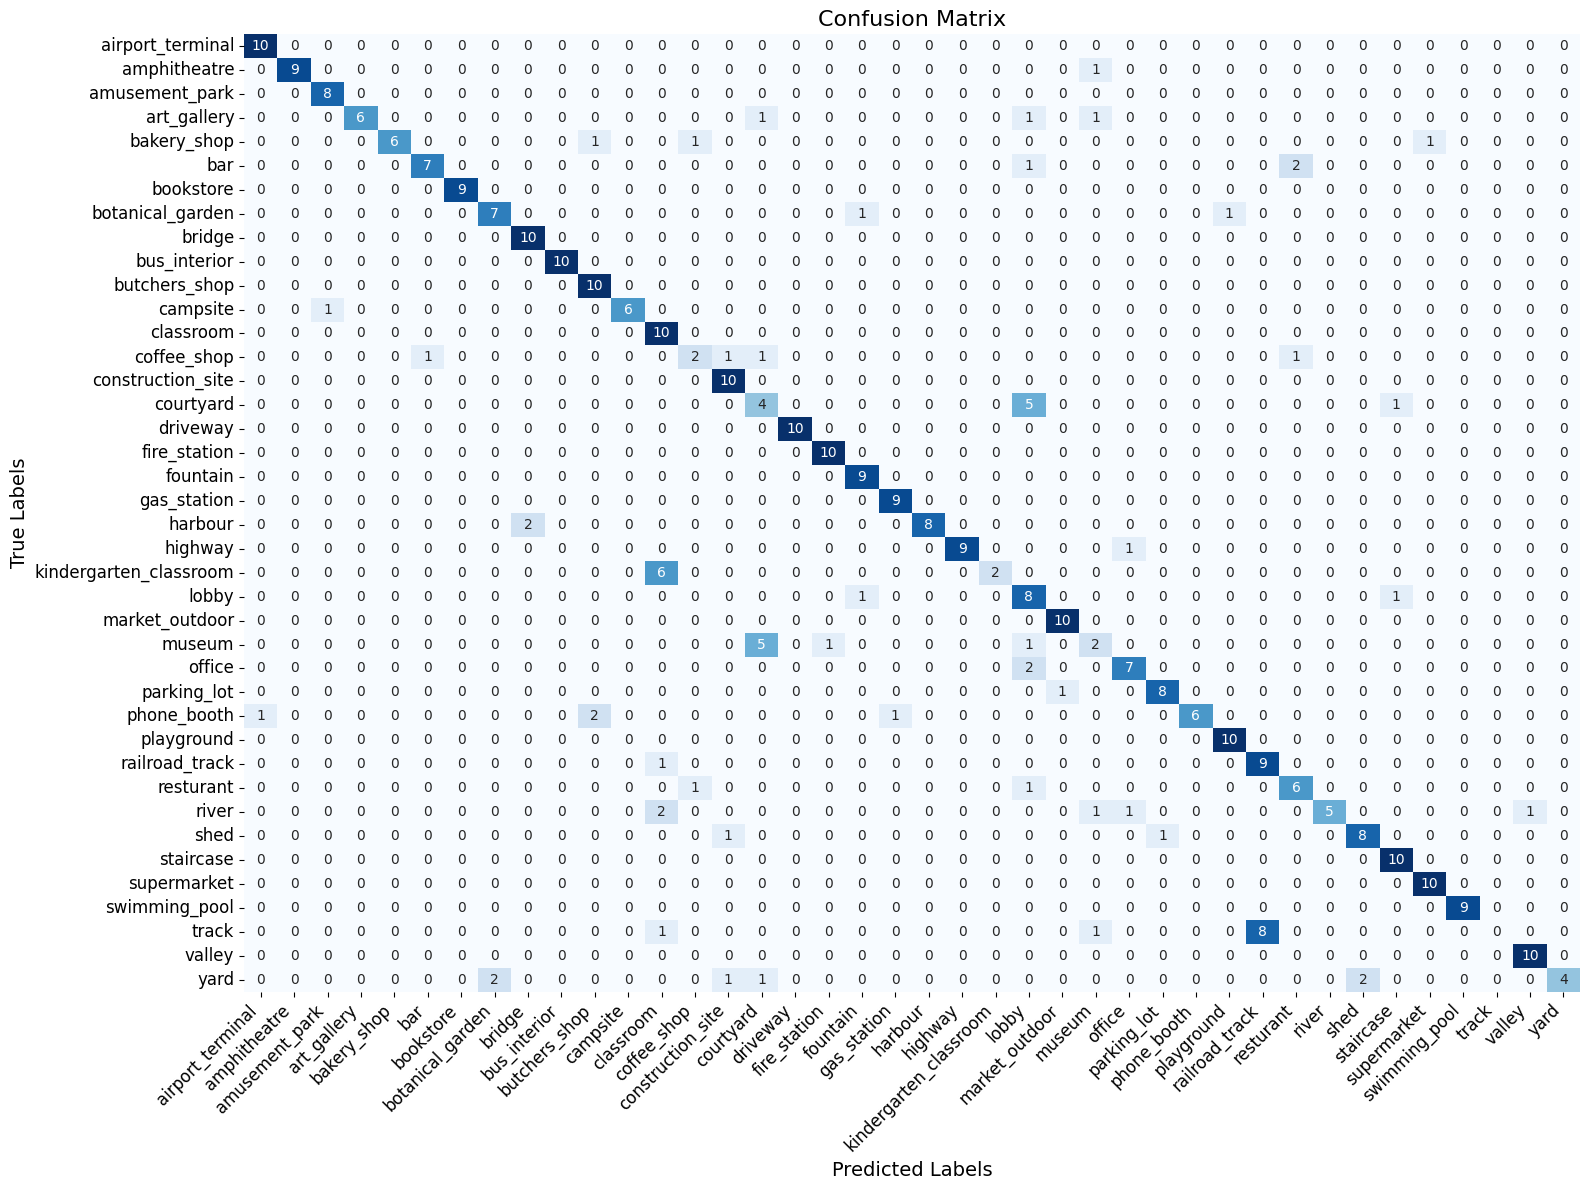

In [6]:
plot_confusion_matrix(
    model=model,
    dataloader=test_loader,
    class_names=test_dataset.classes,
    device="cuda",
    save=False,
)

In [16]:
import torch
import matplotlib.pyplot as plt


def print_misclassified_grid(
    model, val_loader, class_names, device="cuda", max_to_show=20, cols=4
):
    model.eval()
    model.to(device)
    misclassified_images = []
    titles = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)

            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified_images.append(img.cpu())
                    titles.append(f"T: {class_names[label]}\nP: {class_names[pred]}")
                    if len(misclassified_images) >= max_to_show:
                        break
            if len(misclassified_images) >= max_to_show:
                break

    # Plot images in grid
    rows = (len(misclassified_images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    for ax, img, title in zip(axs, misclassified_images, titles):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(title, fontsize=9)
        ax.axis("off")

    # Turn off unused axes
    for i in range(len(misclassified_images), len(axs)):
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

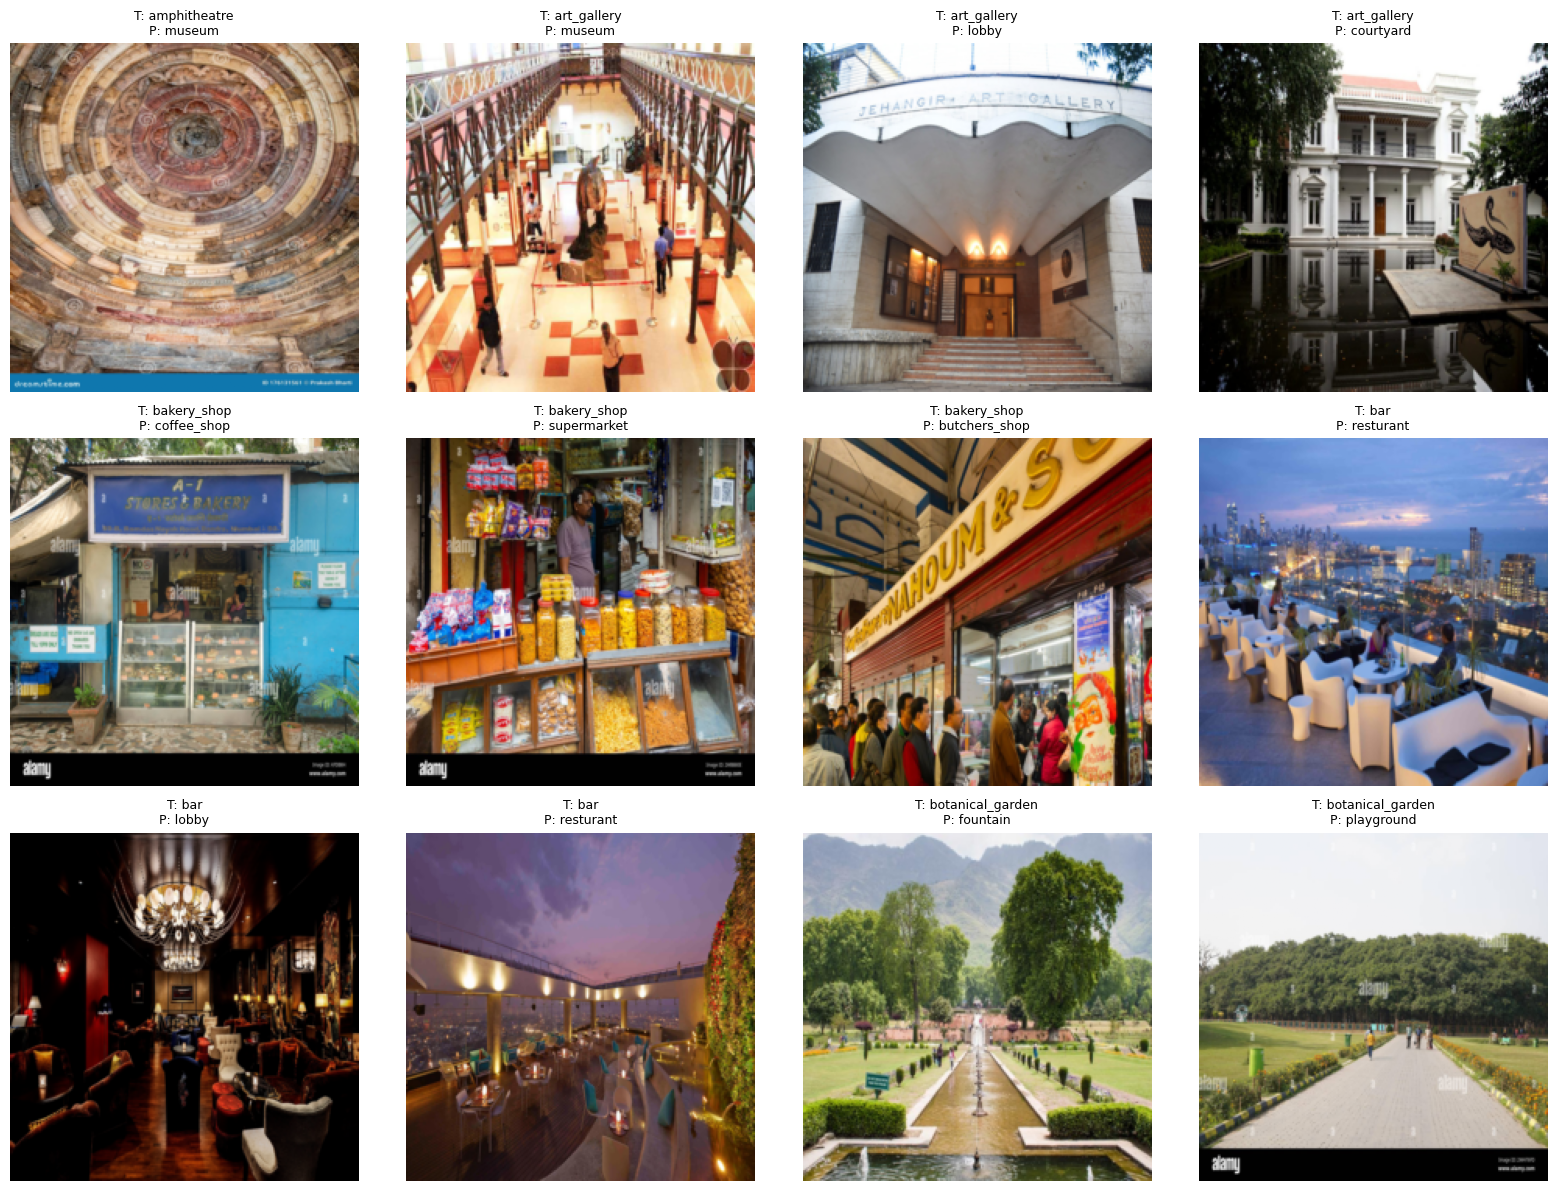

In [15]:
print_misclassified_grid(
    model, test_loader, class_names
)  # T = True Label, P = Predicted

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


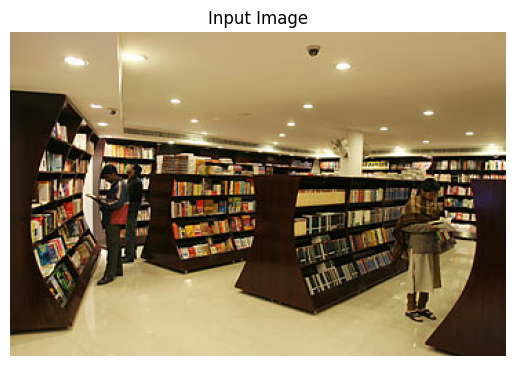

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



Predicted Class: bookstore

Visualizing Attention Heads...


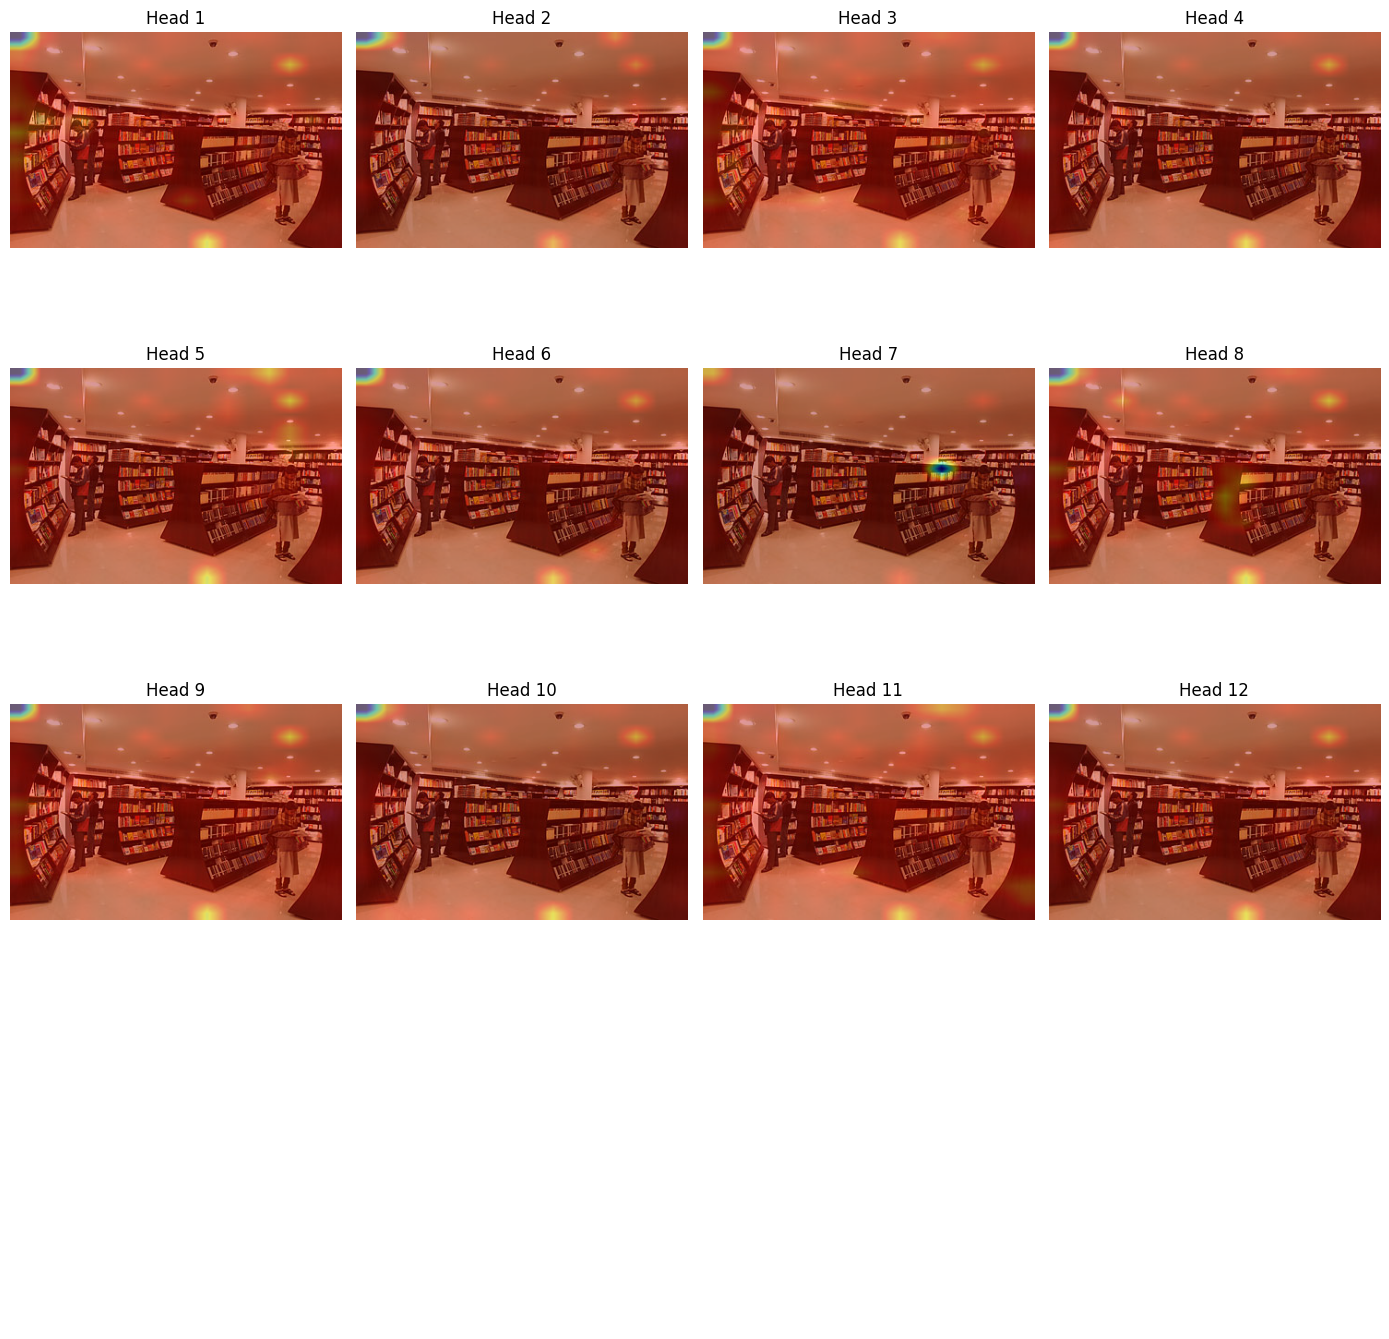

In [6]:
# Vision Transformer Attention Visualizer - Static Image Version

import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from transformers import AutoImageProcessor

# Class labels
CLASS_LABELS = [
    "airport_terminal",
    "amphitheatre",
    "amusement_park",
    "art_gallery",
    "bakery_shop",
    "bar",
    "bookstore",
    "botanical_garden",
    "bridge",
    "bus interior",
    "butchers shop",
    "campsite",
    "classroom",
    "coffee_shop",
    "construction_site",
    "courtyard",
    "driveway",
    "fire_station",
    "fountain",
    "gas_station",
    "harbour",
    "highway",
    "kindergarten_classroom",
    "lobby",
    "market_outdoor",
    "museum",
    "office",
    "parking_lot",
    "phone_booth",
    "playground",
    "railroad_track",
    "restaurant",
    "river",
    "shed",
    "staircase",
    "supermarket",
    "swomming_pool_outdoor",
    "track",
    "valley",
    "yard",
]

# Model options
MODEL_OPTIONS = {
    "DINOv2": ("dinov2", "./dino.pth", "facebook/dinov2-base"),
    "ViT": ("vit_base", "./vit.pth", "google/vit-base-patch16-224"),
    "Swin": ("swin", "./swin.pth", "microsoft/swin-tiny-patch4-window7-224"),
}

# Choose model and image path
selected_model_name = "DINOv2"  # Options: "DINOv2", "ViT", "Swin"
image_path = "/home/nebula/code/cw/scene-recognition-vit/data/test_set/bookstore/bookstore_0.jpg"  # Replace with your custom image path


selected_arch, selected_path, img_processor = MODEL_OPTIONS[selected_model_name]


# Load model
def load_model(arch, path):
    from src.models import load_vit_model

    model = load_vit_model(arch).to("cuda")
    state_dict = torch.load(path, map_location="cuda")
    new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model.eval()
    return model


model = load_model(selected_arch, selected_path)
feature_extractor = AutoImageProcessor.from_pretrained(img_processor)


# Preprocess image
def preprocess_image(img):
    return feature_extractor(images=img, return_tensors="pt")


# Visualize attention heads
def visualize_attention(img, outputs):
    attentions = outputs.attentions
    attn = torch.stack(attentions)[:, 0]
    attn = attn.mean(dim=0)

    num_heads = attn.shape[0]
    num_tokens = attn.shape[-1]

    num_patches = num_tokens - 1
    attn_size = int(np.sqrt(num_patches))
    assert attn_size**2 == num_patches, "Unexpected number of patches"

    w, h = img.size
    grid_size = int(np.ceil(np.sqrt(num_heads)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(14, 14))

    for i in range(num_heads):
        cls_attn = attn[i, 0, 1:].reshape(attn_size, attn_size).detach().cpu().numpy()
        cls_attn = cls_attn / cls_attn.max()
        cls_attn = cv2.resize(cls_attn, (w, h))
        heatmap = cv2.applyColorMap(np.uint8(255 * cls_attn), cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(np.array(img.convert("RGB")), 0.6, heatmap, 0.4, 0)

        ax = axes[i // grid_size, i % grid_size]
        ax.imshow(overlay)
        ax.set_title(f"Head {i + 1}")
        ax.axis("off")

    for i in range(num_heads, grid_size * grid_size):
        axes[i // grid_size, i % grid_size].axis("off")

    plt.tight_layout()
    plt.show()


# Load and display image
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("Input Image")
plt.show()

# Run inference
inputs = preprocess_image(image).to("cuda")
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

logits = outputs.logits
prediction = logits.argmax(dim=-1).item()
print(f"\nPredicted Class: {CLASS_LABELS[prediction]}")

# Visualize attention
print("\nVisualizing Attention Heads...")
visualize_attention(image, outputs)